Frida Lizett Zavala Pérez

A01275226

# Regresión Logistica

Esta es una regresión logistica sin el uso de frameworks.
El data set que usaremos fue recuperado de kaggle.

El conjunto de datos de predicción de diabetes es una colección de datos médicos y demográficos de pacientes, junto con su estado de diabetes (positivo o negativo). Los datos incluyen características como la edad, el género, el índice de masa corporal (IMC), la hipertensión, enfermedades cardíacas, antecedentes de tabaquismo, nivel de HbA1c y nivel de glucosa en sangre. Este conjunto de datos se puede utilizar para construir modelos de aprendizaje automático que predigan la diabetes en pacientes en función de su historial médico e información demográfica. Esto puede ser útil para profesionales de la salud para identificar pacientes que pueden estar en riesgo de desarrollar diabetes y para desarrollar planes de tratamiento personalizados. Además, los investigadores pueden utilizar el conjunto de datos para explorar las relaciones entre varios factores médicos y demográficos y la probabilidad de desarrollar diabetes.



Librerias a utilizar.

NumPy: se usa para operaciones numéricas y matrices eficientes en Python.

Pandas: se emplea para el manejo y análisis de datos tabulares en Python.

Matplotlib: con ella creamos gráficos y visualizaciones en Python.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Procesamiento de los datos

Primero se cargan los datos desde un archivo .csv, y buscamos valores nulos, para evitar algun tipo de error o sesgo en la predicción. También analizamos la columna de género ya que unicamente 18 valores de todo el dataset pertenecen a other, es por ello que se decide eliminar del dataset.

In [4]:
#cargar datos desde archivo
data = pd.read_csv("diabetes_prediction_dataset.csv")

print(data.info())
#Finding null values
print(data.isnull().sum())
#gender column
data.gender.value_counts()

#Drop a other de género para evitar conflicto en las predicciones
data = data.drop(data[data['gender'] == 'Other'].index)
print(data.gender.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Female    58552
Male     

Se traducen algunos de los datos de la columna smoking_history para poder generar mejor las predicciones.

In [5]:
data['smoking_history'] = data['smoking_history'].replace('ever', 'used_to')
data['smoking_history'] = data['smoking_history'].replace('not current', 'used_to')
data['smoking_history'] = data['smoking_history'].replace('former', 'used_to')
data['smoking_history'] = data['smoking_history'].replace('No Info', 'no')
data['smoking_history'] = data['smoking_history'].replace('never', 'no')
data['smoking_history'] = data['smoking_history'].replace('current', 'yes')
print(data.smoking_history.value_counts())


no         70902
used_to    19794
yes         9286
Name: smoking_history, dtype: int64


Una parte importante del análisis de nuestros datos es observar con qué tipo de dato se están trabajando, tenemos datos de tipo string, por lo que con One Hot Encoder generaremos tablas binarias para traducir la información y manejar todos los datos de manera numérica. Observamos cómo quedaría finalmente el dataset y lo guardamos en un archivo nuevo que será con el que trabajaremos en la regresión.

In [6]:
#One Hot Encoding
sex = pd.get_dummies(data['gender'])
new_df = pd.concat([data.drop('gender', axis = 1), sex], axis = 1)

smoke = pd.get_dummies(data['smoking_history'])
new_df = pd.concat([new_df.drop('smoking_history', axis = 1), smoke], axis = 1)

print(new_df.head())

# Guardar el conjunto de datos modificado en un nuevo archivo CSV
new_df.to_csv('new_df.csv', index=False)

data = pd.read_csv('new_df.csv')

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  Female  Male  no  used_to  yes  
0         0       1     0   1        0    0  
1         0       1     0   1        0    0  
2         0       0     1   1        0    0  
3         0       1     0   0        0    1  
4         0       0     1   0        0    1  


## Clasificación con Regresión Logística

Se dividen los datos de X y Y, así como los conjuntos de entrenamiento y prueba. En este caso usaremos una proporción de 80-20%.

Al finalizar la limpieza del dataset quedamos con un conjunto de datos de 99983.

In [7]:
"""INICIA LA CLASIFICACIÓN CON REGRESIÓN LOGISTICA"""

y = data.diabetes
X = data.drop('diabetes', axis = 1)

# Dividir el dataset en conjuntos de entrenamiento y prueba
#se dividen con una proporción de 80% y 20% con slices para train y test respectivamente
X_train = X[0:79986]
X_test = X[79986:99983] #numpy slices of an array

y_train = y[0:79986]
y_test = y[79986:99983] #numpy slices of an array



### Estandarización de los datos

Esta sección calcula la media y la desviación estándar de las características en el conjunto de entrenamiento (X_train) y luego estandariza tanto el conjunto de entrenamiento como el conjunto de prueba. La estandarización es un proceso importante para que todas las características tengan una escala similar.

In [8]:
# Estandarizar las características del dataset a partir del promedio y la desviacion estandar
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

### Agregar término de sesgo (bias)
Aquí, se agrega una columna de unos al principio de los conjuntos de entrenamiento y prueba. Este término de sesgo (bias) es necesario para permitir que el modelo de regresión logística tenga un parámetro independiente para el sesgo.

In [9]:
# Agregar un término de sesgo (bias) a las características
X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]

### Inicialización de parámetros
Se inicializan los parámetros del modelo (coeficientes) con ceros.

In [10]:
# Inicializar parámetros
theta = np.zeros(X_train_bias.shape[1])

### Definición de la función sigmoide

La función sigmoid calcula la función sigmoide, que toma un valor real z y devuelve un valor entre 0 y 1.

In [11]:
# Definir la función sigmoide (regresión logistica) pone los valores entre 0 y 1
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Definición de la función de costo (entropía cruzada)

Esta función calcula la entropía cruzada, que es la función de costo utilizada en la regresión logística para medir la discrepancia entre las predicciones del modelo y las etiquetas reales.

In [12]:
# Definir la función de costo (entropía cruzada)
def cost_function(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    cost = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

### Gradiente descendiente

Esta función implementa el algoritmo de gradiente descendente para ajustar los parámetros del modelo. Calcula las predicciones, el error y actualiza los parámetros en cada iteración. Además, guarda el historial de costos para su posterior análisis.

In [13]:
# Gradiente descendente
def gradient_descent(X, y, theta, learning_rate, num_iterations):
    m = len(y)
    cost_history = []
    for _ in range(num_iterations):
        z = np.dot(X, theta)
        predictions = sigmoid(z)
        error = y - predictions
        gradient = np.dot(X.T, error) / m
        theta += learning_rate * gradient
        cost_history.append(np.mean(np.abs(error)))

    return theta, cost_history

### Hiperparámetros del algoritmo

Aquí se establecen los hiperparámetros del algoritmo, como la tasa de aprendizaje (learning_rate) y el número de iteraciones de entrenamiento (num_iterations).

In [14]:
# Hiperparámetros del algoritmo
learning_rate = 0.03
num_iterations = 1000

### Entrenamiento del modelo

En esta línea, se llama a la función gradient_descent para entrenar el modelo y se obtienen los parámetros ajustados (trained_theta) y el historial de costos (cost_history).

In [15]:
# Entrenar el modelo
trained_theta, cost_history = gradient_descent(X_train_bias, y_train, theta, learning_rate, num_iterations)


### Predicciones y evaluación

Se realizan predicciones en el conjunto de prueba y se calcula el error absoluto entre las predicciones y los valores reales.

In [16]:
# Calcular las predicciones en el conjunto de prueba
y_pred = sigmoid(np.dot(X_test_bias, trained_theta))
y_pred_classes = (y_pred >= 0.5).astype(int)

# Calcular el error absoluto entre predicciones y valores reales
error = np.abs(y_pred_classes - y_test)

### Gráfica de error

Esta parte del código traza un gráfico que muestra cómo disminuye el error durante las iteraciones de entrenamiento. Esto es útil para visualizar el proceso de aprendizaje del modelo.

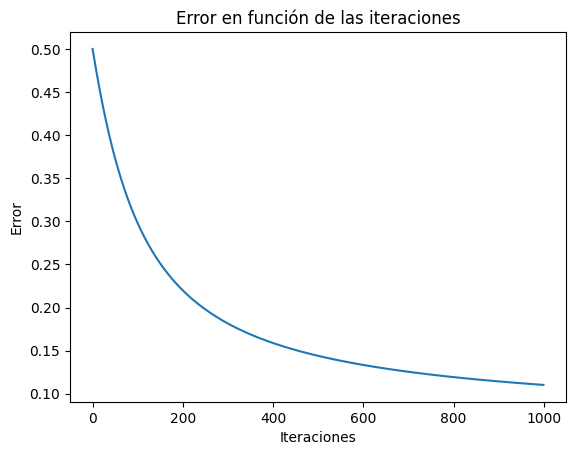

In [17]:
# Graficar el ERROR en función de las iteraciones
plt.plot(cost_history)
plt.xlabel('Iteraciones')
plt.ylabel('Error')
plt.title('Error en función de las iteraciones')
plt.show()

### Visualización de resultados

Aquí, se imprimen los valores predichos y los valores reales del conjunto de prueba. Luego, se crea una gráfica de barras para visualizar la cantidad de predicciones correctas e incorrectas. Finalmente, se calcula y muestra la precisión del modelo.

Se han truncado las últimas 5000 líneas del flujo de salida.
Valor calculado: 0, Valor real: 1
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 1, Valor real: 1
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 1, Valor real: 1
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 1, Valor real: 1
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 1, Valor real: 1
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, Valor real: 0
Valor calculado: 0, V

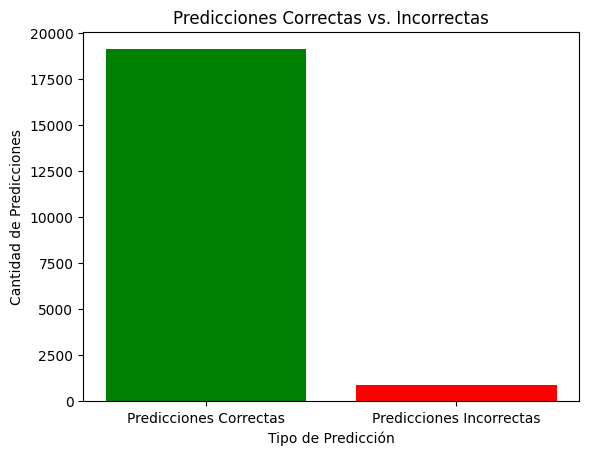

Accuracy del modelo: 95.65%


In [18]:
# Imprimir valores calculados y reales

for i in range(len(y_test)):
    print(f"Valor calculado: {y_pred_classes[i]}, Valor real: {y_test.values[i]}")

"""Gráfica de los valores reales y valores predichos"""

# errores calculados
correct_predictions = len(error) - np.sum(error)
incorrect_predictions = np.sum(error)

# Crear una lista de etiquetas para las barras
labels = ['Predicciones Correctas', 'Predicciones Incorrectas']

# Crear una lista de valores para las barras
values = [correct_predictions, incorrect_predictions]

# Crear la gráfica de barras
plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Tipo de Predicción')
plt.ylabel('Cantidad de Predicciones')
plt.title('Predicciones Correctas vs. Incorrectas')

# Mostrar la gráfica
plt.show()

"""Calcular el accuracy del modelo"""

# Calcular y mostrar el accuracy manualmente
accuracy = correct_predictions / len(y_test) * 100
print(f'Accuracy del modelo: {accuracy:.2f}%')